In [178]:
import pandas as pd 
import numpy as np 
import scipy
# import xlrd 
import sklearn

from Gibbs_model_probit import Gibbs_sampling

from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from utils import baseline_lr,baseline_esnet,baseline_justmean
from utils import baseline_LogitElsnet,baseline_justmode,baseline_random,baseline_LogitLR,baseline_RanForest,baseline_Gibbs_zhe,baseline_SVM
from utils import baseline_LogitElsnet_leaveone,baseline_LogitLR_leaveone,baseline_SVM_leaveone

from sklearn.model_selection import KFold
from scipy.stats import binom 
from scipy.stats import norm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange
from Gibbd_zhe import GibbsSampling3
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
import time
from sklearn.preprocessing import StandardScaler

In [179]:
# data_loading 
np.random.seed(123)

data_table = pd.read_csv('../data/processed/all_feature_p1_lip_group_binary_v1.csv')
# data_table = pd.read_csv('../data/processed/all_feature_p1_lip_group_binary_v2.csv')
# data_table = pd.read_csv('../data/processed/all_feature_p1_lip_group_v3.csv')
# data_table = pd.read_csv('../data/processed/all_feature_p1_lip_group_v4.csv')

target = '1= death; 0=alive'#'gap_surv_time_class' 'ADT_if_fail'


# normalization

# min-max
df = data_table[target]


# check nan
data_table[target].isnull().values.any()
# data_table.fillna(data_table.mean(), inplace=True) # fill nan with column mean

False

In [180]:
all_feature = data_table.iloc[:,1:-7]
#lip_feature = data_table.iloc[:,1:775]#for p2
# lip_feature = data_table.iloc[:,1:-372]#for p1
# gene_feature = data_table.iloc[:,775:-7]#for p1

Y = data_table[target].values
X = all_feature.values
# X = gene_feature.values


In [181]:
X.shape

(71, 185)

In [182]:
X=X[:,82:82+103]

In [183]:
# # leave-one test on 
# loo = LeaveOneOut()
# X = X_r
# N = loo.get_n_splits(X)

# lr_acc = np.zeros(N)
# esnet_acc = np.zeros(N)
# mode_acc = np.zeros(N)
# random_acc = np.zeros(N)
# svm_acc = np.zeros(N)




# for i,index in enumerate(loo.split(X)):
#     train_index, test_index = index
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
#     data_dict = {'X_tr':X_train, 'y_tr':y_train, 'X_test':X_test, 'y_test':y_test}
#     dict_lr = baseline_LogitLR_leaveone(data_dict)
#     dict_els = baseline_LogitElsnet_leaveone(data_dict)
#     # dict_rf = baseline_RanForest(data_dict)
#     dict_mode = baseline_justmode(data_dict)
#     dict_random = baseline_random(data_dict)
#     dict_svm = baseline_SVM_leaveone(data_dict)

#     lr_acc[i] = dict_lr['acr']
#     esnet_acc[i] = dict_els['acr']

#     mode_acc[i] = dict_mode['acr']
#     random_acc[i] = dict_random['acr']
#     svm_acc[i] = dict_svm['acr']

# print('lr_acr_mean: %.4f,lr_acr_std: %.4f '%(lr_acc.mean(),lr_acc.std() ) )
# print('esnet_acr_mean: %.4f,esnet_acr_std: %.4f '%(esnet_acc.mean(),esnet_acc.std() ) )
# print('svm_acr_mean: %.4f,rf_acr_mean: %.4f '%(svm_acc.mean(),svm_acc.std() ) )
# print('just-mode_acr_mean: %.4f,mode_acr_std: %.4f '%(mode_acc.mean(),mode_acc.std() ) )
# print('just-random_acr_mean: %.4f,just-random_acr_std: %.4f '%(random_acc.mean(),random_acc.std() ) )

In [184]:
# PCA analysis

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

lw = 2
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

pca = PCA(n_components=30)
X_r = pca.fit(X_new).transform(X_new)
# colors = ['navy',  'darkorange']
# target_names = ['dead','live']

# for color, i, target_name in zip(colors, [0, 1], target_names):
#     plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('PCA of p1_dead_or_live (with all lip and gene feature)')
# plt.show()
print(pca.singular_values_)
print(pca.explained_variance_ratio_.cumsum())
# singular_values_ of first 20 principle-components

[22.85009698 17.26253205 15.17880564 14.91435185 13.47144266 13.00414995
 12.25855358 11.86599723 11.28163271 10.45633837 10.26576341  9.66626608
  9.22732878  9.16888903  8.90584157  8.77893114  8.55744243  8.51318439
  8.48612313  8.48612313  8.48612313  8.48612313  8.48612313  7.81412711
  7.30137655  7.17945912  6.66358988  6.25695677  6.10134181  6.04392137]
[0.14142116 0.22213487 0.28453903 0.34478764 0.39394251 0.43974639
 0.48044848 0.51858551 0.55305875 0.58267279 0.61121718 0.63652506
 0.65958671 0.68235717 0.70383983 0.7247146  0.74454933 0.76417942
 0.78368492 0.80319041 0.82269591 0.8422014  0.8617069  0.87824552
 0.89268487 0.90664604 0.91867297 0.92927685 0.93935983 0.94925392]


In [185]:
X.shape

(71, 103)

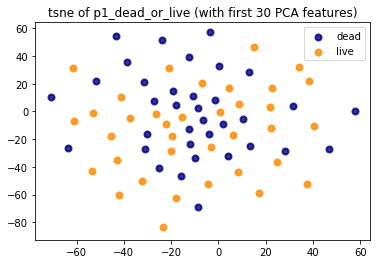

In [191]:
# visulize the x_r with t-sne, target：dead or live
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_r)
colors = ['navy',  'darkorange']
target_names = ['dead','live']
# X_embedded.shape
target = '1= death; 0=alive'# 'ADT_if_fail'
Y = data_table[target].values


for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_dead_or_live (with first 30 PCA features)')
plt.show()

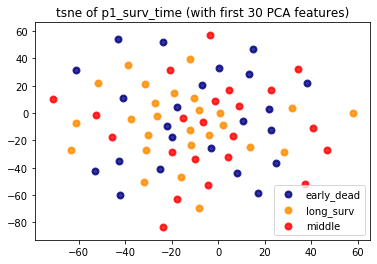

In [192]:
#  visulize the x_r with t-sne, target：surv_time
from sklearn.manifold import TSNE

target = 'gap_surv_time_class'# 'ADT_if_fail'
Y = data_table[target].values


# X_embedded = TSNE(n_components=2).fit_transform(X_r)
colors = ['navy',  'darkorange', 'red']
target_names = ['early_dead','long_surv','middle']
# X_embedded.shape

for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_surv_time (with first 30 PCA features)')
plt.show()

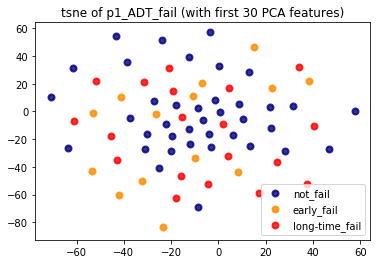

In [193]:
#  visulize the x_r with t-sne, target：ADT_fail
from sklearn.manifold import TSNE

target = 'ADT_start_fail'
Y = data_table[target].values
Y_new = np.zeros(len(Y)) 
Y_new[np.argwhere(Y>=0)]=1
Y_new[np.argwhere(Y>365)]=2


# X_embedded = TSNE(n_components=2).fit_transform(X_r)
colors = ['navy',  'darkorange', 'red']
target_names = ['not_fail','early_fail','long-time_fail']
# X_embedded.shape

for color, i, target_name in zip(colors, [0.0, 1,2], target_names):
    plt.scatter(X_embedded[Y_new == i, 0], X_embedded[Y_new == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_ADT_fail (with first 30 PCA features)')
plt.show()

In [189]:
# leave-one test on raw feature
target = '1= death; 0=alive'
Y = data_table[target].values


loo = LeaveOneOut()
# X = X_r
N = loo.get_n_splits(X)

lr_acc = np.zeros(N)
esnet_acc = np.zeros(N)
mode_acc = np.zeros(N)
random_acc = np.zeros(N)
svm_acc = np.zeros(N)




for i,index in enumerate(loo.split(X)):
    train_index, test_index = index
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    data_dict = {'X_tr':X_train, 'y_tr':y_train, 'X_test':X_test, 'y_test':y_test}
    dict_lr = baseline_LogitLR_leaveone(data_dict)
    dict_els = baseline_LogitElsnet_leaveone(data_dict)
    # dict_rf = baseline_RanForest(data_dict)
    dict_mode = baseline_justmode(data_dict)
    dict_random = baseline_random(data_dict)
    dict_svm = baseline_SVM_leaveone(data_dict)

    lr_acc[i] = dict_lr['acr']
    esnet_acc[i] = dict_els['acr']

    mode_acc[i] = dict_mode['acr']
    random_acc[i] = dict_random['acr']
    svm_acc[i] = dict_svm['acr']

print('lr_acr_mean: %.4f,lr_acr_std: %.4f '%(lr_acc.mean(),lr_acc.std() ) )
print('esnet_acr_mean: %.4f,esnet_acr_std: %.4f '%(esnet_acc.mean(),esnet_acc.std() ) )
print('svm_acr_mean: %.4f,rf_acr_mean: %.4f '%(svm_acc.mean(),svm_acc.std() ) )
print('just-mode_acr_mean: %.4f,mode_acr_std: %.4f '%(mode_acc.mean(),mode_acc.std() ) )
print('just-random_acr_mean: %.4f,just-random_acr_std: %.4f '%(random_acc.mean(),random_acc.std() ) )

lr_acr_mean: 0.6197,lr_acr_std: 0.4855 
esnet_acr_mean: 0.6056,esnet_acr_std: 0.4887 
svm_acr_mean: 0.5775,rf_acr_mean: 0.4940 
just-mode_acr_mean: 0.0000,mode_acr_std: 0.0000 
just-random_acr_mean: 0.4789,just-random_acr_std: 0.4996 


In [190]:
# leave-one test on PCA features
target = '1= death; 0=alive'
Y = data_table[target].values


loo = LeaveOneOut()
X = X_r
N = loo.get_n_splits(X)

lr_acc = np.zeros(N)
esnet_acc = np.zeros(N)
mode_acc = np.zeros(N)
random_acc = np.zeros(N)
svm_acc = np.zeros(N)




for i,index in enumerate(loo.split(X)):
    train_index, test_index = index
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    data_dict = {'X_tr':X_train, 'y_tr':y_train, 'X_test':X_test, 'y_test':y_test}
    dict_lr = baseline_LogitLR_leaveone(data_dict)
    dict_els = baseline_LogitElsnet_leaveone(data_dict)
    # dict_rf = baseline_RanForest(data_dict)
    dict_mode = baseline_justmode(data_dict)
    dict_random = baseline_random(data_dict)
    dict_svm = baseline_SVM_leaveone(data_dict)

    lr_acc[i] = dict_lr['acr']
    esnet_acc[i] = dict_els['acr']

    mode_acc[i] = dict_mode['acr']
    random_acc[i] = dict_random['acr']
    svm_acc[i] = dict_svm['acr']

print('lr_acr_mean: %.4f,lr_acr_std: %.4f '%(lr_acc.mean(),lr_acc.std() ) )
print('esnet_acr_mean: %.4f,esnet_acr_std: %.4f '%(esnet_acc.mean(),esnet_acc.std() ) )
print('svm_acr_mean: %.4f,rf_acr_mean: %.4f '%(svm_acc.mean(),svm_acc.std() ) )
print('just-mode_acr_mean: %.4f,mode_acr_std: %.4f '%(mode_acc.mean(),mode_acc.std() ) )
print('just-random_acr_mean: %.4f,just-random_acr_std: %.4f '%(random_acc.mean(),random_acc.std() ) )

G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

lr_acr_mean: 0.4930,lr_acr_std: 0.5000 
esnet_acr_mean: 0.4930,esnet_acr_std: 0.5000 
svm_acr_mean: 0.4789,rf_acr_mean: 0.4996 
just-mode_acr_mean: 0.0000,mode_acr_std: 0.0000 
just-random_acr_mean: 0.4789,just-random_acr_std: 0.4996 


G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_